# Spotify Recommendation System: Genre Pattern Analysis

This notebook compares the genre distribution patterns of songs clustered using two methods: `Hierarchical Clustering` and `Decision Tree-based segmentation`. The ultimate goal is to understand genre separability across clusters to inform a recommendation engine focused on `mpb`, `rock`, and `death metal`.

### Step 1: Importing necessary libraries

We begin by importing essential libraries for data manipulation and visualization.


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 10)


### Step 2: Load DataFrames

We load:
- `DecisionTreeDF`: The output of a Decision Tree classifier where each song is assigned to a leaf node (interpreted as a cluster).
- `df_cluster_PCA_gp`: The result of hierarchical clustering with PCA annotations and genre information.


In [2]:
DecisionTreeDF = pd.read_csv("Data for Modeling/AftDTsMPBROCKMETAL_KGDf.csv")
df_cluster_PCA_gp = pd.read_csv("Data for Modeling/NoMODEdf_cluster_PCA_gp.csv")


### Step 3: Drop Unnecessary Columns

Both DataFrames contain irrelevant or placeholder columns like unnamed indices or extra spaces. We drop those for clarity.


In [3]:
del DecisionTreeDF[" "]
del DecisionTreeDF["Unnamed: 0"]
del df_cluster_PCA_gp ["Unnamed: 0"]


### Step 4: Preview Cleaned DataFrames

In [4]:
DecisionTreeDF

,index,node_id,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,210,6g2BiiVQqY5v1S4HIrM54F,Rodrigo Amarante,Tuyo (Narcos Theme) [Extended Version] [A Netf...,Tuyo (Narcos Theme) [Extended Version] - A Net...,66,151565,False,0.765,...,-7.806,0,0.0402,0.492000,0.366000,0.1430,0.4570,112.195,4,mpb
1,1,210,6Dc2tCivms1s2X9myWe4ni,Rodrigo Amarante,Tuyo (Narcos Theme) [A Netflix Original Series...,Tuyo (Narcos Theme) - A Netflix Original Serie...,65,89293,False,0.720,...,-13.338,0,0.0690,0.474000,0.084700,0.1550,0.5460,112.219,4,mpb
2,2,163,76HOOcFt3lKVdScmoScfz1,Djavan,"Djavan ""Ao Vivo""",Azul (Ao Vivo),49,259066,False,0.632,...,-8.658,0,0.0401,0.756000,0.000004,0.7260,0.6520,119.567,4,mpb
3,3,158,4crctLJMKJekuqQ7cQLpHV,Nicolas Candido;Olívia,Apaga a Luz (feat. Olívia),Apaga a Luz (feat. Olívia),49,216446,False,0.610,...,-10.889,0,0.0462,0.815000,0.000000,0.1230,0.5530,96.313,4,mpb
4,4,158,0XXwP0EmpOEqWxcL9aSreJ,Fábio Jr.,Fabio Jr.,Pareço um Menino,50,273906,False,0.580,...,-13.703,1,0.0295,0.596000,0.000001,0.0849,0.3730,136.408,4,mpb
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,2995,125,78adEMnfn1XolaOh2QAjZS,Brujeria,Brujerizmo,Laboratorio Cristalitos,20,91866,False,0.474,...,-5.850,1,0.1270,0.000432,0.030100,0.3380,0.1550,128.239,4,death-metal
2996,2996,21,53c9YHuifgAWJoqgPOgPUn,Unleashed,Gods of Death Metal,Long Before Winter's Call,0,227616,False,0.370,...,-4.465,1,0.1310,0.000078,0.006220,0.1270,0.0398,103.052,4,death-metal
2997,2997,125,6us7QqYJGMGZqej8dKCFGC,Bury Your Dead,Cover Your Tracks,Mission: Impossible,21,162973,True,0.307,...,-3.552,0,0.2790,0.000033,0.010600,0.3110,0.4880,83.527,4,death-metal
2998,2998,209,5l5XKQmo9M0XHdNAPddq0i,Surra,Bica na Cara,Vida de Babaca,22,135893,True,0.362,...,-1.722,1,0.1260,0.038000,0.000268,0.3600,0.4540,103.668,4,death-metal


In [5]:
df_cluster_PCA_gp

,track_genre,index,popularity,duration_ms,explicit,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,cluster_x,PC1,PC2,PCA_EuclidianDist(Xsign),1th_Boundary
0,mpb,0,66,151565,False,0.765,0.497,1,-7.806,0.0402,0.492000,0.366000,0.1430,0.4570,112.195,38,0.317817,-0.460902,0.731332,1
1,mpb,1,65,89293,False,0.720,0.422,1,-13.338,0.0690,0.474000,0.084700,0.1550,0.5460,112.219,38,0.506695,-0.451429,0.881122,1
2,mpb,2,49,259066,False,0.632,0.651,7,-8.658,0.0401,0.756000,0.000004,0.7260,0.6520,119.567,20,0.553200,0.084895,0.807674,1
3,mpb,3,49,216446,False,0.610,0.420,4,-10.889,0.0462,0.815000,0.000000,0.1230,0.5530,96.313,45,0.672430,-0.223854,0.949204,1
4,mpb,4,50,273906,False,0.580,0.330,7,-13.703,0.0295,0.596000,0.000001,0.0849,0.3730,136.408,30,0.546521,0.038317,0.797442,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,death-metal,2995,20,91866,False,0.474,0.993,1,-5.850,0.1270,0.000432,0.030100,0.3380,0.1550,128.239,102,-0.310477,-0.375755,-0.380591,-1
2996,death-metal,2996,0,227616,False,0.370,0.993,7,-4.465,0.1310,0.000078,0.006220,0.1270,0.0398,103.052,100,-0.379712,0.135940,-0.187896,-1
2997,death-metal,2997,21,162973,True,0.307,0.976,2,-3.552,0.2790,0.000033,0.010600,0.3110,0.4880,83.527,7,-0.683685,-0.299595,-0.527105,-1
2998,death-metal,2998,22,135893,True,0.362,0.994,6,-1.722,0.1260,0.038000,0.000268,0.3600,0.4540,103.668,14,-0.642556,0.053592,-0.396197,-1


### Step 5: Merge Genre and Track Info with Clustering Data

We merge the `track_genre` and `track_id` columns from the Decision Tree DataFrame into the hierarchical clustering DataFrame to allow direct comparison of cluster compositions.


In [6]:
df_cluster_PCA_gp_Genre = pd.merge(DecisionTreeDF["track_genre"], df_cluster_PCA_gp, right_index=True, left_index=True)
df_cluster_PCA_gp_Genre = pd.merge(DecisionTreeDF["track_id"], df_cluster_PCA_gp_Genre, right_index=True, left_index=True)
df_cluster_PCA_gp_Genre.sort_values(by="cluster_x")
del df_cluster_PCA_gp_Genre["track_genre_y"]
df_cluster_PCA_gp_Genre = df_cluster_PCA_gp_Genre.rename(columns={'track_genre_x': 'track_genre'}, inplace=False)



### Step 6: Define Cluster Counting Function

This function calculates how many tracks of each genre appear in each cluster (both Decision Tree and Hierarchical). It distinguishes between `mpb`, `rock`, and all other genres which are grouped into `metal`.


In [7]:
def countingOcorencies(df, columnname, clusterIDs):
    grouped = df.groupby([columnname, "track_genre"]).size().unstack(fill_value=0)
    grouped = grouped.reindex(clusterIDs, fill_value=0)
    grouped = grouped.rename(columns={"mpb": "QntMPB", "rock": "QntROCK"})

    if "QntMPB" not in grouped.columns:
        grouped["QntMPB"] = 0
    if "QntROCK" not in grouped.columns:
        grouped["QntROCK"] = 0

    grouped["QntMETAL"] = (
        df.groupby(columnname).size()
        .reindex(clusterIDs, fill_value=0)
        - grouped["QntMPB"]
        - grouped["QntROCK"]
    )

    grouped = grouped.reset_index().rename(columns={columnname: "Cluster"}).drop_duplicates()
    ids_count = len(df)

    return grouped, ids_count

d, i = countingOcorencies(df_cluster_PCA_gp_Genre, "cluster_x", list(df_cluster_PCA_gp_Genre["cluster_x"]))
d1, i2 = countingOcorencies(DecisionTreeDF, "node_id", (DecisionTreeDF["node_id"].sort_values()).to_list())
d_sorted = d.sort_values("Cluster")
d1_sorted = d1.sort_values("Cluster")


### Step 7: Heatmap for Hierarchical Clustering (106 Clusters)

We generate a heatmap showing how many songs from each genre fall into each cluster obtained from hierarchical clustering.


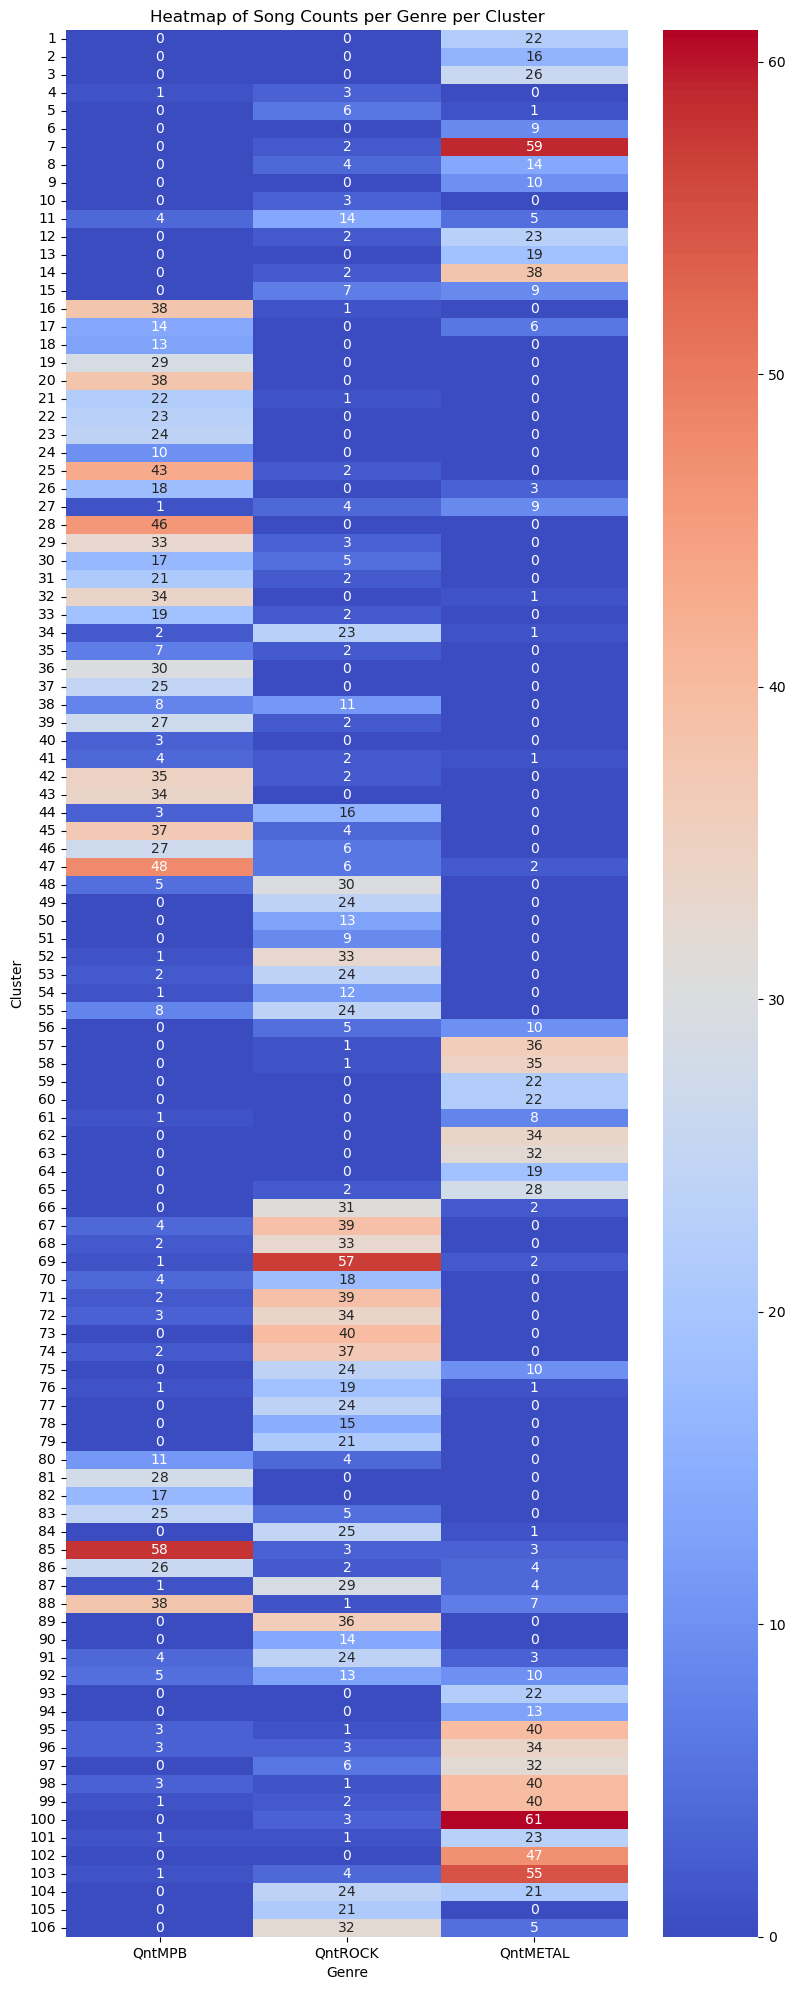

In [8]:
for col in ["QntMPB", "QntROCK", "QntMETAL"]:
    d_sorted[col] = d_sorted[col].apply(lambda x: list(x)[0] if isinstance(x, set) else x)

heatmap_data = d_sorted.set_index("Cluster")[["QntMPB", "QntROCK", "QntMETAL"]]

plt.figure(figsize=(8, 20))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", fmt="d")
plt.title("Heatmap of Song Counts per Genre per Cluster")
plt.xlabel("Genre")
plt.ylabel("Cluster")
plt.tight_layout()
plt.show()


### Step 8: Heatmap for Decision Tree Leaf Nodes (106 Nodes)

This heatmap visualizes the genre distribution across each leaf node (interpreted as a cluster) in the Decision Tree.


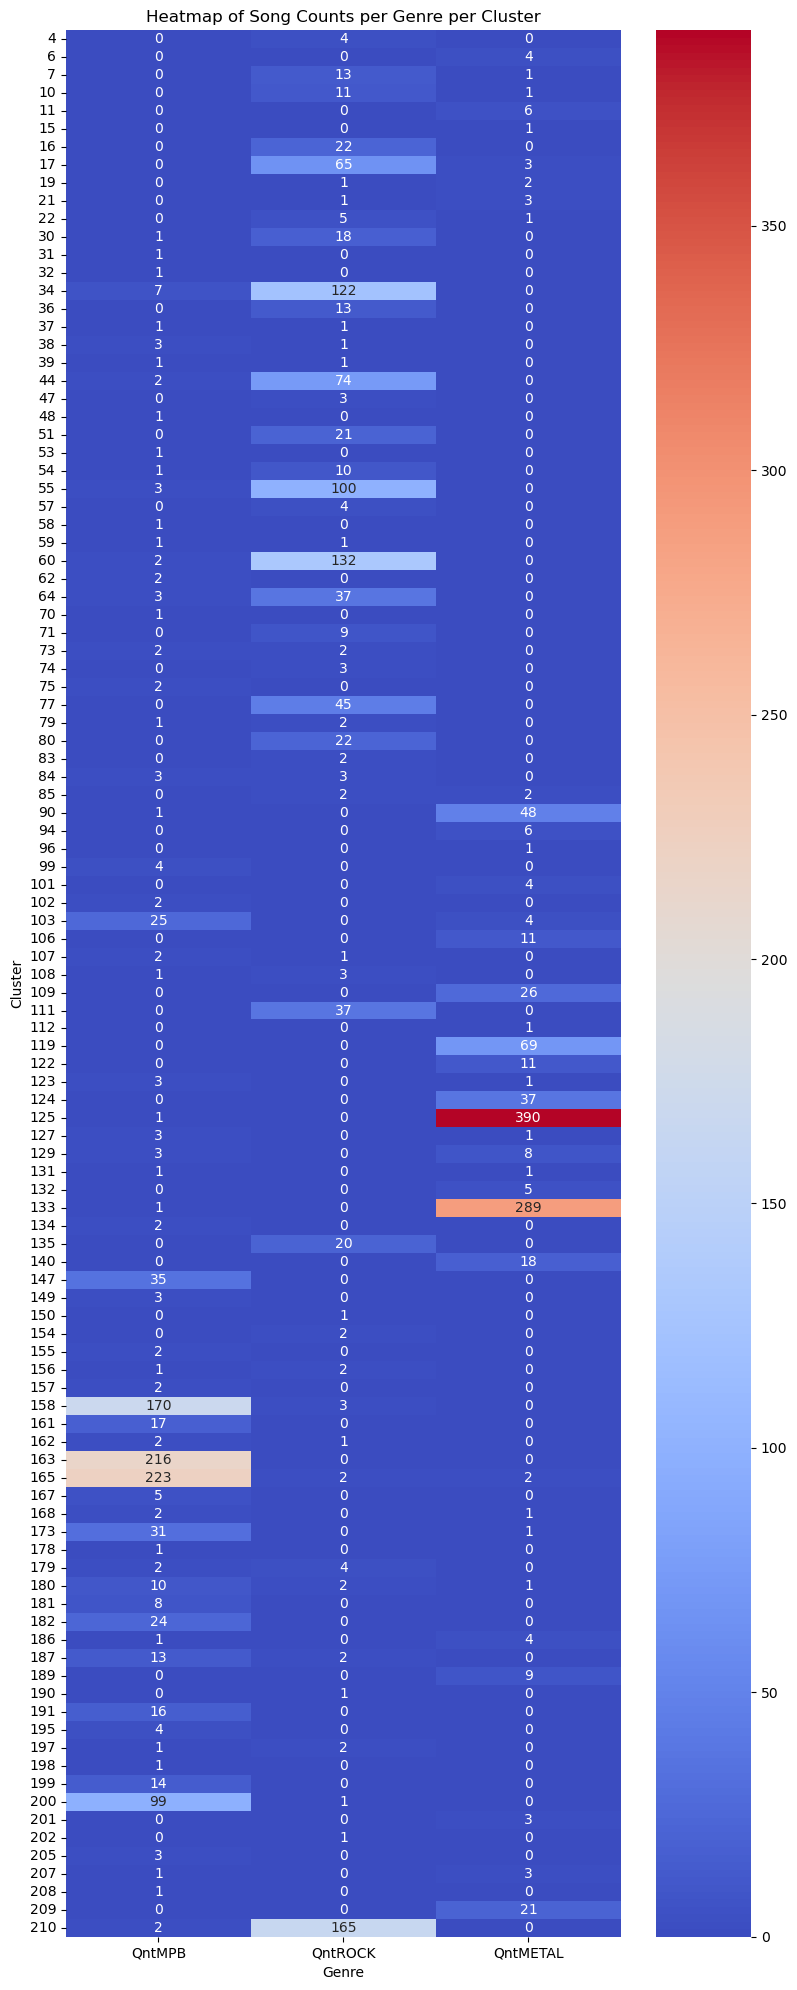

In [9]:
for col in ["Cluster", "QntMPB", "QntROCK", "QntMETAL"]:
    d1[col] = d1[col].apply(lambda x: list(x)[0] if isinstance(x, set) else x)

heatmap_data = d1.set_index("Cluster")[["QntMPB", "QntROCK", "QntMETAL"]]

plt.figure(figsize=(8, 20))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", fmt="d")
plt.title("Heatmap of Song Counts per Genre per Cluster")
plt.xlabel("Genre")
plt.ylabel("Cluster")
plt.tight_layout()
plt.show()


In [12]:
from sklearn.cluster import KMeans

def cluster_pca_data( df_cluster_PCA_gp, n_clusters=106):
    """
    Performs KMeans clustering on PC1 and PC2 of the input DataFrame.
    
    Parameters:
        df_cluster_PCA_gp (pd.DataFrame): DataFrame containing 'PC1' and 'PC2' columns.
        n_clusters (int): Number of clusters to form (default is 106).
    
    Returns:
        pd.DataFrame: Original DataFrame with an added 'cluster' column.
    """
    # Extract PCA features
    X = df_cluster_PCA_gp[["PC1", "PC2"]]
    
    # Fit KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X)
    
    # Add cluster labels to the DataFrame
    df_clustered = df_cluster_PCA_gp.copy()
    df_clustered["cluster"] = cluster_labels
    
    return df_clustered

cluster_pca_df = cluster_pca_data( df_cluster_PCA_gp)
cluster_pca_df

,track_genre,index,popularity,duration_ms,explicit,danceability,energy,key,loudness,speechiness,...,instrumentalness,liveness,valence,tempo,cluster_x,PC1,PC2,PCA_EuclidianDist(Xsign),1th_Boundary,cluster
0,mpb,0,66,151565,False,0.765,0.497,1,-7.806,0.0402,...,0.366000,0.1430,0.4570,112.195,38,0.317817,-0.460902,0.731332,1,100
1,mpb,1,65,89293,False,0.720,0.422,1,-13.338,0.0690,...,0.084700,0.1550,0.5460,112.219,38,0.506695,-0.451429,0.881122,1,85
2,mpb,2,49,259066,False,0.632,0.651,7,-8.658,0.0401,...,0.000004,0.7260,0.6520,119.567,20,0.553200,0.084895,0.807674,1,92
3,mpb,3,49,216446,False,0.610,0.420,4,-10.889,0.0462,...,0.000000,0.1230,0.5530,96.313,45,0.672430,-0.223854,0.949204,1,60
4,mpb,4,50,273906,False,0.580,0.330,7,-13.703,0.0295,...,0.000001,0.0849,0.3730,136.408,30,0.546521,0.038317,0.797442,1,84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,death-metal,2995,20,91866,False,0.474,0.993,1,-5.850,0.1270,...,0.030100,0.3380,0.1550,128.239,102,-0.310477,-0.375755,-0.380591,-1,15
2996,death-metal,2996,0,227616,False,0.370,0.993,7,-4.465,0.1310,...,0.006220,0.1270,0.0398,103.052,100,-0.379712,0.135940,-0.187896,-1,4
2997,death-metal,2997,21,162973,True,0.307,0.976,2,-3.552,0.2790,...,0.010600,0.3110,0.4880,83.527,7,-0.683685,-0.299595,-0.527105,-1,51
2998,death-metal,2998,22,135893,True,0.362,0.994,6,-1.722,0.1260,...,0.000268,0.3600,0.4540,103.668,14,-0.642556,0.053592,-0.396197,-1,53


In [13]:
d3, i4 = countingOcorencies(cluster_pca_df, "cluster", list(cluster_pca_df["cluster"]))


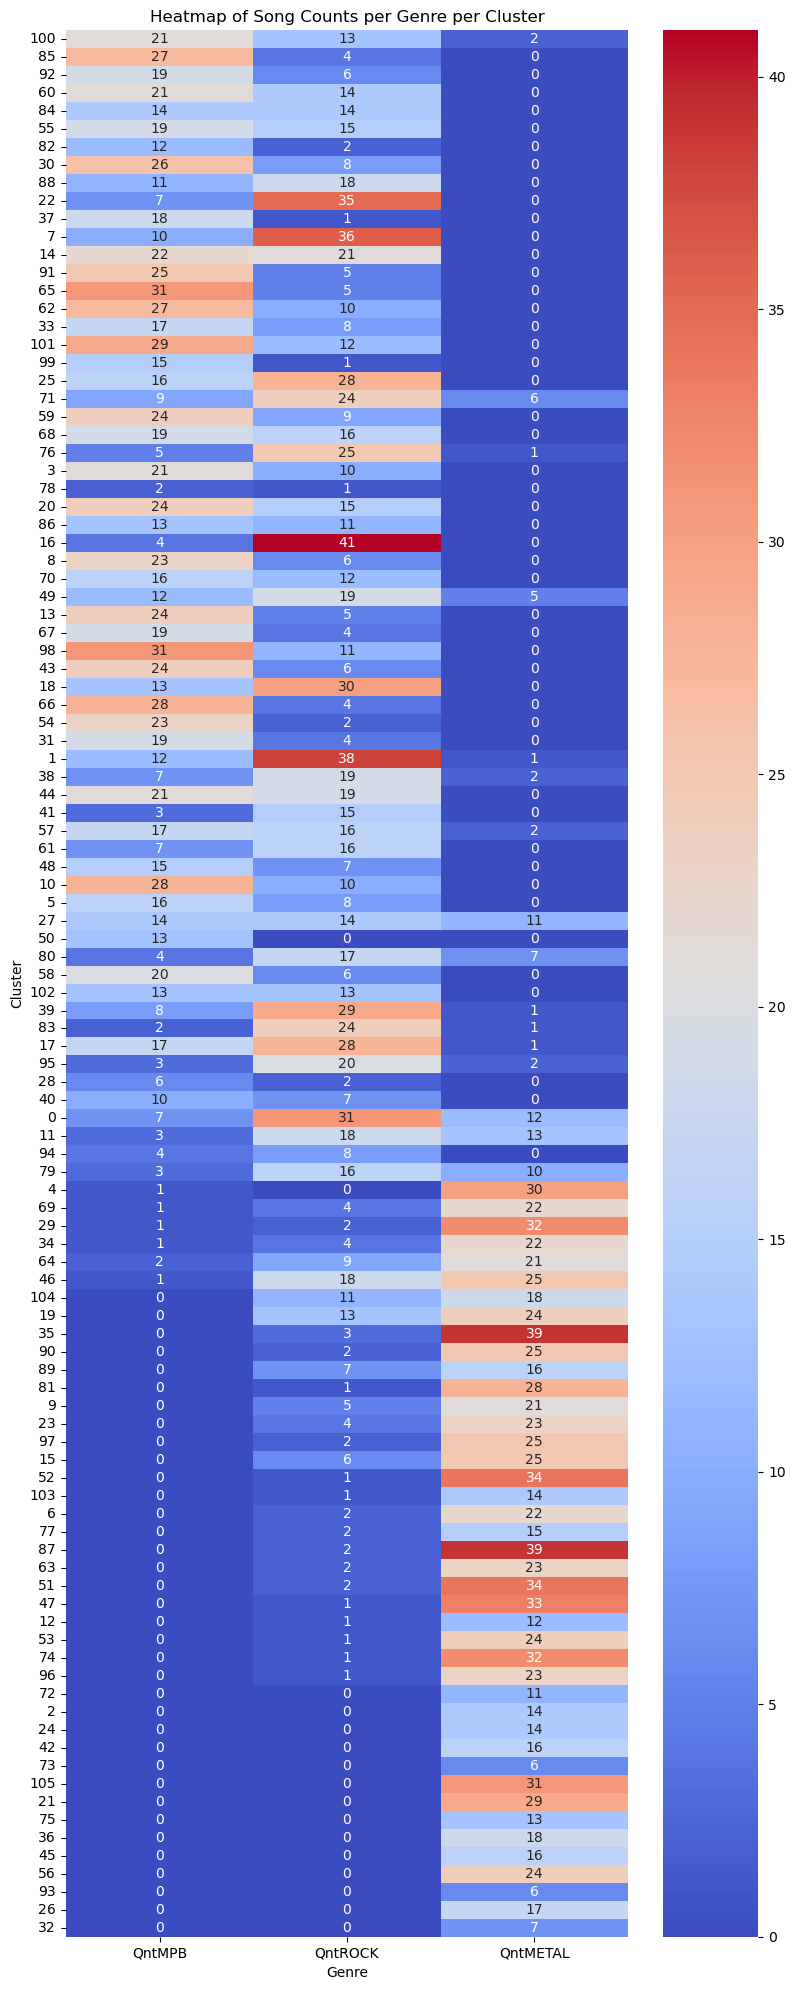

In [14]:
for col in ["Cluster", "QntMPB", "QntROCK", "QntMETAL"]:
    d1[col] = d3[col].apply(lambda x: list(x)[0] if isinstance(x, set) else x)

heatmap_data = d3.set_index("Cluster")[["QntMPB", "QntROCK", "QntMETAL"]]

plt.figure(figsize=(8, 20))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", fmt="d")
plt.title("Heatmap of Song Counts per Genre per Cluster")
plt.xlabel("Genre")
plt.ylabel("Cluster")
plt.tight_layout()
plt.show()
